# Alternate Least Squares Model for Anime Recomendations

## Creating the model

### Importing basic libraries

In [44]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from threadpoolctl import threadpool_limits
import os

### Getting data

We need to get data from provided databases and format it so we can make the matrix and factorize it later. Getting rid of watched but not rated entires in the ratings table (there is no point in keeping unrated data, this way we reset it to unrated instead of having it misinterpreted as rated 0), as well as rows with missing data from the anime table.

Source of the data: [link](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database)

In [48]:
# Load and prepare data
file_path = "./../data"
anime = pd.read_csv(file_path + "/anime.csv")
ratings = pd.read_csv(file_path + "/rating.csv")

# Clean data
anime = anime.dropna(subset=["genre", "rating"])
ratings = ratings.dropna(subset=["anime_id", "user_id"])
anime = anime.dropna(subset=["anime_id"])
ratings = ratings[ratings["rating"] != -1]

# Ensure we only include anime_ids that exist in the anime dataset
valid_anime_ids = set(anime["anime_id"].unique())
ratings = ratings[ratings["anime_id"].isin(valid_anime_ids)]

### Format data for the model
More data related stuff. Creating mappings between indexes and ids. then makig sure there are no missing indexes by dropping it. There is so much data that deleting stuff makes little difference. We still end up with a big data set at the end

In [49]:
# Create mappings
anime_id_to_index = {anime_id: idx for idx,
                     anime_id in enumerate(sorted(valid_anime_ids))}
user_id_to_index = {user_id: idx for idx,
                    user_id in enumerate(sorted(ratings["user_id"].unique()))}

# Create reverse mappings
index_to_anime_id = {idx: anime_id for anime_id,
                     idx in anime_id_to_index.items()}
index_to_user_id = {idx: user_id for user_id, idx in user_id_to_index.items()}


# Add index mappings to ratings
ratings["anime_idx"] = ratings["anime_id"].map(anime_id_to_index)
ratings["user_idx"] = ratings["user_id"].map(user_id_to_index)
ratings = ratings.dropna(subset=["anime_idx", "user_idx"])

# Validate mappings
print("Validation checks:")
print("All anime IDs valid:", ratings['anime_id'].isin(
    anime_id_to_index.keys()).all())
print("All user IDs valid:", ratings['user_id'].isin(
    user_id_to_index.keys()).all())
print("Number of unique anime:", len(anime_id_to_index))
print("Number of unique users:", len(user_id_to_index))

Validation checks:
All anime IDs valid: True
All user IDs valid: True
Number of unique anime: 12017
Number of unique users: 69600


### Matrix creation

Creating matrix in a user x anime format filling it with existing ratings and leaving all the other spaces empty, making it a sparse matrix (mostly empty). Then we will convert it to CSR format and apply confidence weighing (both will be explained below).

In [50]:
# Create sparse matrix of user-anime interactions
interaction_matrix = coo_matrix(
    (ratings["rating"], (ratings["user_idx"], ratings["anime_idx"])),
    shape=(len(user_id_to_index), len(anime_id_to_index)),
).tocsr()

print("Interaction Matrix Shape:", interaction_matrix.shape)

# Apply confidence weighting
interaction_matrix.data = 1 + np.log1p(interaction_matrix.data)

Interaction Matrix Shape: (69600, 12017)


### CSR (compressed sparse row) format and confidence weighting
CSR makes the row access and matrix-vector multiplications faster. Attaching an example from Wikipedia as it is great at illustarting the concept.

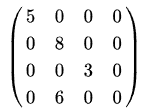 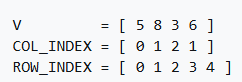


Applying logarythmic confidence weighting to our data helps with accuracy of the model and adds more confidence into rating values.

## Training model

At the end we feed our prepared matrix to an ALS (alternating least squares) algorithm. Basic idea of matrix factorization with ALS algorithm is we take the interaction matrix and split it into two matrices both with the same amout of features (in our case we would split it into user and anime). We dont control what the features are, it is the machine learning magic. Next based on those two smaller matrices when we want to get info from an empty value in the main matrix, we perform simple vertex multiplication between the proper user vector and anime vector. If we want to find the best recommendations for a certain user we simply multiply that users vector by the whole anime matrix to fill in the squares and then pick the best values from the new data.
But how do we actually find the two matrices? That's what ALS is for. ALS works by alternating between two steps:
1. fixing 1st matrix and predicting the 2nd one
2. fixing 2nd matrix and predicting the 1st one

After a set number of iterations we get a proper set of matrices that we will use to help us predict empty squares.

In [51]:
# Limit OpenBLAS threads for performance
os.environ["OPENBLAS_NUM_THREADS"] = "1"

with threadpool_limits(limits=1, user_api="blas"):
    model = AlternatingLeastSquares(
        factors=50, regularization=0.01, iterations=15)
    model.fit(interaction_matrix)

print("ALS model training completed!")

100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

ALS model training completed!


## Using the model

### Define the function to recommend

In [52]:
def recommend_anime(user_id, model, interaction_matrix, anime_df, n_recommendations=10):
    """
    Generate anime recommendations for a specific user.

    Parameters:
    -----------
    user_id : int
        The ID of the user to generate recommendations for
    model : AlternatingLeastSquares
        Trained ALS model
    interaction_matrix : scipy.sparse.csr_matrix
        User-anime interaction matrix in CSR format
    anime_df : pandas.DataFrame
        DataFrame containing anime metadata
    n_recommendations : int
        Number of recommendations to generate

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing recommended anime with their metadata and scores
    """
    try:
        # Convert user_id to internal user index
        if user_id not in user_id_to_index:
            raise KeyError(f"User ID {user_id} not found in training data")
        
        user_idx = user_id_to_index[user_id]

        # Get user recommendations
        user_items = interaction_matrix[user_idx]
        
        # Get recommendations
        ids, scores = model.recommend(
            user_idx,
            user_items,
            N=n_recommendations,
            filter_already_liked_items=True,
            recalculate_user=True
        )

        # Map anime indices back to anime_ids
        recommended_anime_ids = [index_to_anime_id[idx] for idx in ids]

        # Get recommended anime details
        recommended_anime = anime_df[anime_df['anime_id'].isin(recommended_anime_ids)].copy()

        # Add recommendation scores
        score_dict = dict(zip(recommended_anime_ids, scores))
        recommended_anime['score'] = recommended_anime['anime_id'].map(score_dict)

        # Sort by score and select relevant columns
        result = recommended_anime[['name', 'genre', 'type', 'rating', 'score']].sort_values(
            by='score', ascending=False
        )

        return result

    except KeyError as e:
        print(f"Error: {str(e)}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Unexpected error: {str(e)}")
        return pd.DataFrame()

### Using the function

In [55]:
test_user_id = 1
recommendations = recommend_anime(test_user_id, model, interaction_matrix, anime)

if not recommendations.empty:
    print(f"\nRecommendations for User {test_user_id}:")
    print(recommendations)
else:
    print(f"\nNo recommendations available for User {test_user_id}")


Recommendations for User 1:
                                              name  \
86                              Shingeki no Kyojin   
445                               Mirai Nikki (TV)   
159                                   Angel Beats!   
702                                        Another   
40                                      Death Note   
2132                           Sword Art Online II   
118                                No Game No Life   
760                                     Elfen Lied   
288                                     Fairy Tail   
4240  Highschool of the Dead: Drifters of the Dead   

                                                  genre type  rating     score  
86         Action, Drama, Fantasy, Shounen, Super Power   TV    8.54  0.430095  
445   Action, Mystery, Psychological, Shounen, Super...   TV    8.07  0.359986  
159         Action, Comedy, Drama, School, Supernatural   TV    8.39  0.337136  
702     Horror, Mystery, School, Supernatural, Thril